# Redundancy Reduction in Bimetallic Nanoparticle Data Sets via Iterative Archetypal Analysis

**author:** Jonathan Yik Chang Ting

**email:** Jonathan.Ting@anu.edu.au

This is a notebook to reduce the redundancy in bimetallic nanoparticle data sets using the iterative archetypal analysis functionalities provided by *archetypes.py*.

## Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

from os import chdir, getcwd
import pickle
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import cdist
import seaborn as sns
import sklearn
from sklearn.datasets import load_diabetes, make_blobs
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

chdir('/scratch/q27/jt5911/iterative-archetypal-analysis')
from PIAA import *
from archetypes import create_simplex_ax, map_alfa_to_simplex, plot_radar_datapoint, plot_tsne


# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  scipy: {scipy.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")

Versions of imported libraries:
  matplotlib: 3.8.2
  numpy: 1.26.0
  pandas: 2.1.3
  scipy: 1.11.4
  seaborn: 0.13.0
  scikit-learn: 1.3.2


In [2]:
# General variables
DATA_DIR = f"{getcwd()}/data"
RANDOM_STATE = 42
VERBOSE = True
NUM_JOBS = 48

# Variables specific for figures plotting
DPI = None
FIG_SIZE = (7, 4)
sns.set_style('ticks')

# Variables specific for splitting data into subsets
SHUFFLE = True  # Whether to shuffle data samples before splitting.

# Variables specific for archetypes.py functionalities
C = 0.0001  # constraint coefficient to ensure that the summation of alpha and beta equals to 1.

# Variables specific for the archetypal analysis algorithm provided by the SPArse Modeling Software (SPAMS) package
ROBUST = False  # Whether to use modified AA algorithm to deal with outliers
TOLERANCE = 0.001  # Threshold to decide when to stop optimisation.
COMPUTE_XTX = False  # Whether to compute X^T * X
STEPS_FISTA = 3  # Number of steps for fast iterative shrinkage-thresholding algorithm
STEPS_AS = 50  # Number of steps for active set algorithm
RANDOM_INIT = False  # Whether to initialise the archetypes randomly

# Directory paths
SUBSETS_PICKLES_PATH="/scratch/q27/jt5911/iterative-archetypal-analysis/data/subsetsDataPKLs"
OUTPUTS_PICKLES_PATH="/scratch/q27/jt5911/iterative-archetypal-analysis/data/subsetsOutputsPKLs"
PBS_SCRIPT_DIR="/scratch/q27/jt5911/iterative-archetypal-analysis/PBSscripts"

# Set random seed
np.random.seed(RANDOM_STATE)

### Arguments Description
- **n_archetypes**: Defines how many archetypes will be extracted. A positive integer. Setting to 1 return the mean of the data set. *Default = 2*.
- **iterative**: Whether to use the iterative or classical approach. *Default = False*.
- **n_subsets**: The number of subsets to split the data into if **iterative** = True. *Default = 10*.
- **shuffle**: Whether to shuffle the data samples before splitting. *Default = True*.
- **only_archetypes**: Whether to stop running when archetypes are computed. Setting to True allows only archetypes and run time to be returned. *Default = False*.
- **C**: the weight on the constraint equation. Inversely proportional to the strength of constraint. *Default = 0.0001*. Constraint Equation: $$\sum\alpha = 1,$$ $$\sum\beta = 1$$

The following arguments are specific to the archetypal analysis algorithm provided by the [SPArse Modeling Software (SPAMS) package](https://thoth.inrialpes.fr/people/mairal/spams/), hence Users are directed to their homepage and the original publication describing the algorithm in "[Fast and Robust Archetypal Analysis for Representation Learning](https://ieeexplore.ieee.org/document/6909588)" for up-to-date and detailed descriptions.
- **robust**
- **tolerance**
- **computeXtX**
- **stepsFISTA**
- **stepsAS**
- **randominit**
- **random_state**
- **numThreads**

## General Functions

In [3]:
def loadCSV(csvFilePath, isMono=True, molLabels=True, ele='Au', transFrac=True):
    """
    The monometallic dataset has different naming for certain features, hence why 'isMono' needs to be specified.
    """
    featDF = pd.read_csv(csvFilePath, sep=',', header=0)
    

    if isMono:
        featDF = featDF.rename(columns={'N_total': 'N_atom_total', 'N_bulk': 'N_atom_bulk', 'N_surface': 'N_atom_surface', 
                                        'Avg_total': 'TCN_avg', 'Avg_bulk': 'BCN_avg', 'Avg_surf': 'SCN_avg', 
                                        'Avg_bonds': 'BL_avg', 'Std_bonds': 'BL_std', 'Max_bonds': 'BL_max', 'Min_bonds': 'BL_min', 'N_bonds': 'BL_num',
                                        'angle_avg': 'BA1_avg', 'angle_std': 'BA1_std'}, 
                               inplace=False)
        eleSpecificFeats = [feat for feat in featDF.columns if 'CN_' in feat 
                                                            or 'BL_' in feat
                                                            or 'BA1_' in feat]
        # Rename and generate element-specific features to match bimetallic and trimetallic feature names
        eleSpecNewFeatNamesDict = {}
        for feat in eleSpecificFeats:
            eleSpecNewFeatName = f"MMM_{feat}" if 'BA1_' in feat else f"MM_{feat}"
            eleSpecNewFeatNamesDict[feat] = eleSpecNewFeatName
            eleSpecNewFeatName = f"{ele}{ele}{ele}_{feat}" if 'BA1_' in feat else f"{ele}{ele}_{feat}"
            featDF[eleSpecNewFeatName] = featDF[feat]
        featDF = featDF.rename(columns=eleSpecNewFeatNamesDict, inplace=False)
            
        # Rename q6q6 features to match bimetallic and trimetallic q6q6 feature names
        q6q6Feats = [feat for feat in featDF.columns if 'q6q6_T' in feat or 'q6q6_B' in feat or 'q6q6_S' in feat]
        q6q6NewFeatNamesDict = {}
        for feat in q6q6Feats:
            q6q6NewFeatName = f"{feat[:6]}_{feat[6:]}"
            q6q6NewFeatNamesDict[feat] = q6q6NewFeatName
        featDF = featDF.rename(columns=q6q6NewFeatNamesDict, inplace=False)
    
    # Replace count features with percentages
    if transFrac:
        bulkAtomFeats = [feat for feat in featDF.columns if ('BCN' in feat and '_avg' not in feat)
                                                         or ('BGCN' in feat and '_avg' not in feat)
                                                         or ('q6q6_B' in feat and '_avg' not in feat)]
        surfAtomFeats = [feat for feat in featDF.columns if 'N_Au' in feat or 'N_Pd' in feat or 'N_Pt' in feat
                                                         or ('SCN' in feat and '_avg' not in feat)
                                                         or ('SGCN' in feat and '_avg' not in feat)
                                                         or ('SOCN' in feat and '_avg' not in feat)
                                                         or ('SOGCN' in feat and '_avg' not in feat)
                                                         or ('q6q6_S' in feat and '_avg' not in feat)
                                                         or 'Curve' in feat
                                                         or 'S_100' in feat
                                                         or 'S_111' in feat
                                                         or 'S_110' in feat
                                                         or 'S_311' in feat]
        totAtomFeats = [feat for feat in featDF.columns if 'N_Au' in feat or 'N_Pd' in feat or 'N_Pt' in feat
                                                        or ('TCN' in feat and '_avg' not in feat)
                                                        or ('TGCN' in feat and '_avg' not in feat)
                                                        or ('q6q6_T' in feat and '_avg' not in feat)
                                                        or 'FCC' in feat 
                                                        or 'HCP' in feat
                                                        or 'ICOS' in feat
                                                        or 'DECA' in feat]
        numBulkAtomFeat = featDF['N_atom_bulk']
        numSurfAtomFeat = featDF['N_atom_surface']
        numTotalAtomFeat = featDF['N_atom_total']
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for feat in bulkAtomFeats:
                featDF[f"Frac_{feat}"] = featDF[feat] / numBulkAtomFeat
            for feat in surfAtomFeats:
                if 'N_Au' in feat or 'N_Pd' in feat or 'N_Pt' in feat:
                    featDF[f"Frac_{feat}_Surf"] = featDF[feat] / numSurfAtomFeat
                else:
                    featDF[f"Frac_{feat}"] = featDF[feat] / numSurfAtomFeat
            for feat in totAtomFeats:
                featDF[f"Frac_{feat}"] = featDF[feat] / numTotalAtomFeat
        # featDF.drop(bulkAtomFeats, axis=1, inplace=True)
        # featDF.drop(surfAtomFeats, axis=1, inplace=True)
        # featDF.drop(totAtomFeats, axis=1, inplace=True)

    for feat  in featDF.columns.tolist():
        if 'Vol' in feat:  # Turn the units of volumes from cubic angstroms into cubic metres
            featDF[feat] = featDF[feat].apply(lambda x: 1e-30 / x)
        elif 'R_' in feat:  # Turn the units of radii into nanometres
            featDF[feat] = featDF[feat].apply(lambda x: x / 10)
        if feat == 'R_avg':  # Compute average diameter (nm)
            diameterFeat = featDF[feat].rename(feat.replace('R_avg', 'D_avg')) * 2
            featDF = pd.concat([featDF, diameterFeat], axis=1)
    labelFeats = [feat for feat in featDF.columns if 'Surf_defects' in feat or 'Surf_micros' in feat or 'Surf_facets' in feat or '_E' in feat]
    labelDF = featDF[labelFeats]
    featDF.drop(['ID'] + labelFeats, axis=1, inplace=True)
    return featDF, labelDF

In [4]:
def rmNullLowVarFeats(featsDF, rmNull=False, varThresh=0.0, verbose=False):
    if rmNull:
        if verbose:
            print(f"Removing the features with null values...")
            print(f"  Original number of features: {len(featsDF.columns)}")
        featsToDrop = []
        for feat in featsDF.columns:
            if featsDF[feat].isnull().any():
                featsToDrop.append(feat)
        featsDF.drop(featsToDrop, axis=1, inplace=True)
        if verbose:
            print(f"  Total number of features left: {len(featsDF.columns)}\n")
    if verbose:
        print(f"Removing the features with variance below {varThresh:.2f}...")
        print(f"  Original number of features: {len(featsDF.columns)}")
    featsToDrop = []
    for feat in featsDF.columns:
        if featsDF[feat].var() <= varThresh:
            if verbose:
                print(f"    {feat}:    {featsDF[feat].var():.3f}")
            featsToDrop.append(feat)
    featsNoLowVarDF = featsDF.drop(featsToDrop, axis=1, inplace=False)
    if verbose:
        print(f"  Total number of features left: {len(featsNoLowVarDF.columns)}\n")
    return featsNoLowVarDF

In [5]:
def plotAAoutputs(Xscaled, AAclassical, AAiterative,
                  plotSubsets=True, figName='',
                  figSize=(7, 4), dpi=300, verbose=False):
    """Plot the data and archetypes from both approaches."""
    Zclassical, Ziterative = AAclassical.archetypes, AAiterative.archetypes
    # if verbose:
    #     print(f"Archetype set from classical approach:\n{Zclassical}")
    #     print(f"Archetype set from iterative approach:\n{Ziterative}")
    
    plt.figure(figsize=figSize, dpi=dpi)
    if not plotSubsets:
        plt.scatter(Xscaled[:, 0], Xscaled[:, 1], marker='.', s=5) # color='y', 
    else:
        for idxs in AAiterative.subsets_sample_idxs: 
            plt.scatter(Xscaled[idxs, 0], Xscaled[idxs, 1], marker='.', s=5)
    all_subsets_Zs =  np.concatenate(AAiterative.subsets_Zs, axis=1)
    plt.plot(Zclassical[0, :], Zclassical[1, :], 'X', markersize=9, markeredgecolor='k', markeredgewidth=0.8, color='r', alpha=0.5)  # color='m'
    plt.plot(Ziterative[0, :], Ziterative[1, :], 'X', markersize=9, markeredgecolor='k', markeredgewidth=0.8, color='b', alpha=0.5)  # color='c'
    plt.plot(all_subsets_Zs[0, :], all_subsets_Zs[1, :], 'D', markersize=4, markeredgecolor='k', markeredgewidth=0.6, color='y')  # color='b'
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(linestyle='dotted')
    legendEntries = [f"Data Subset {i+1}" for i in range(len(AAiterative.subsets_sample_idxs))] if plotSubsets else ['Data']
    legendEntries += [f"Classical Approach Archetypes, ExpVar: {AAclassical.explained_variance_:.3f}", f"Iterative Approach Archetypes, ExpVar: {AAiterative.explained_variance_:.3f}", 'Archetypes from Split Sets']
    plt.legend(legendEntries, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=False, fontsize='x-small')
    plt.tight_layout()
    plt.savefig(f"figures/AA_{figName}.png", bbox_inches='tight')

In [89]:
# def runCAA(Xscaled, numArchetypes=4, robust=False, onlyZ=False, randomState=42, verbose=False):
#     AAreference = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=False, robust=robust, only_archetypes=onlyZ,
#                                      C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
#                                      random_state=randomState, numThreads=NUM_JOBS)
#     AAreference.fit(Xscaled)
#     if verbose:
#         print(f"Reference archetypal analysis execution time: {AAreference.run_time:.3f} s")
#         print(f"Explained variance: {AAreference.explained_variance_:.3f}\n")
#     return AAreference

In [75]:
def runPIAA1(Xscaled, numArchetypes=4, numSubset=4, shuffle=True, randomState=42, 
             datasetType='uniformSquare', numCPUs=48, wallTime='01:00:00', mem=190, verbose=False):
    splitRunTime = subsetSplit(Xscaled, n_subsets=numSubset, dataName=datasetType, subsetsPicklesPath=SUBSETS_PICKLES_PATH,
                               shuffle=shuffle, random_state=randomState, verbose=verbose)
    # Arguments: (i) dataset name, (ii) number of archetypes, (iii) number of CPUs, (iv) walltime, (v) memory (GB)
    !./runAAs.sh {datasetType} {numArchetypes} {numCPUs} {wallTime} {mem}
    return splitRunTime

In [58]:
def runPIAA2(Xscaled, numArchetypes=4, numSubset=4, onlyZ=False,
             robust=False, shuffle=True, randomState=RANDOM_STATE, 
             datasetType='uniformSquare', verbose=False, splitRunTume=0.0):
    AAiterative = fitPIAA(Xscaled, n_archetypes=numArchetypes, numSubset=numSubset, 
                          dataName=datasetType, outputsPicklesPath=OUTPUTS_PICKLES_PATH, 
                          shuffle=shuffle, robust=robust, only_archetypes=onlyZ, C=0.0001, tolerance=TOLERANCE, 
                          computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                          random_state=randomState, numThreads=NUM_JOBS, splitRunTime=splitRunTime, verbose=verbose)
    if verbose:
        print(f"Parallel iterative archetypal analysis {numSubset} subsets execution time: {AAiterative.run_time:.3f} s\n")
    return AAiterative

In [9]:
def runAAonData(Xscaled, AAreference, AAiterative,
                datasetType='uniformSquare', plotSubsets=True, figSize=(7, 4), dpi=300, verbose=False):
    colourSubsetsStr = 'colourSubsets' if plotSubsets else 'colourWholeSet'
    plotAAoutputs(Xscaled, AAreference, AAiterative,
                  plotSubsets=plotSubsets, figName=f"{datasetType}_{numSubset}-fold_{colourSubsetsStr}",
                  figSize=figSize, dpi=dpi, verbose=verbose)

In [6]:
def runAAonData(Xscaled, numArchetypes=4, numSubsets=[4], runClassical=True, onlyZ=False,
                robust=False, shuffle=True, randomState=42, 
                datasetType='uniformSquare', plotSubsets=True, 
                figSize=(7, 4), dpi=300, verbose=False):
    AAclassical = None
    if runClassical:
        AAclassical = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=False, robust=robust, only_archetypes=onlyZ,
                                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                                         random_state=randomState, numThreads=NUM_JOBS)
        AAclassical.fit(Xscaled)
        if verbose:
            print(f"Classical archetypal analysis execution time: {AAclassical.run_time:.3f} s")
    # Elbow plot for iterative approach
    for (i, numSubset) in enumerate(numSubsets):
        AAiterative = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=robust, only_archetypes=onlyZ, n_subsets=numSubset, shuffle=shuffle, 
                                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                                         random_state=randomState, numThreads=NUM_JOBS)
        AAiterative.fit(Xscaled)
        if verbose:
            print(f"Iterative archetypal analysis {numSubset} subsets execution time: {AAiterative.run_time:.3f} s")
        if not onlyZ:
            colourSubsetsStr = 'colourSubsets' if plotSubsets else 'colourWholeSet'
            plotAAoutputs(Xscaled, AAclassical, AAiterative,
                          plotSubsets=plotSubsets, figName=f"{datasetType}_{numSubset}-fold_{colourSubsetsStr}",
                          figSize=figSize, dpi=dpi, verbose=verbose)
    return AAclassical, AAiterative

The following functionalities are covered:
- extraction of the archetype attributes, 
- mapping of data to the archetype space,
- visualisation of archetype profiles (contributions of the archetypes in describing any other data sample), 
- identification of the most archetypal data samples, 
- visualisation of the data samples and archetypes on parallel axis.

## Load Data

In [7]:
TRANS_FRAC = False
VAR_THRESH = 0

In [8]:
# # MNPs
# # Gold nanoparticle data set doesn't contain these labels: {Surf_defects_*, Surf_micros_*, Surf_facets_*}
# AuFeatsDF, AuOriLabelsDF = loadCSV('data/Au_nanoparticle_dataset.csv', isMono=True, molLabels=False, ele='Au', transFrac=TRANS_FRAC)  
# PdFeatsDF, PdOriLabelsDF = loadCSV('data/Pd_nanoparticle_dataset.csv', isMono=True, molLabels=True, ele='Pd', transFrac=TRANS_FRAC)
# PtFeatsDF, PtOriLabelsDF = loadCSV('data/Pt_nanoparticle_dataset.csv', isMono=True, molLabels=True, ele='Pt', transFrac=TRANS_FRAC)
# MNPFeatsDF = pd.concat([AuFeatsDF, PdFeatsDF, PtFeatsDF], axis=0)
# MNPFeatsDF = MNPFeatsDF.reset_index(inplace=False)
# MNPFeatsDF = MNPFeatsDF.drop(['index'], axis=1, inplace=False)
# MNPFeatsDF = rmNullLowVarFeats(featsDF=MNPFeatsDF, rmNull=True, varThresh=VAR_THRESH, verbose=VERBOSE)

# del AuOriLabelsDF, PdOriLabelsDF, PtOriLabelsDF

In [9]:
# # BNPs
# AuPdFeats, AuPdOriLabels = loadCSV('data/AuPd_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del AuPdOriLabels
# AuPtFeats, AuPtOriLabels = loadCSV('data/AuPt_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del AuPtOriLabels
# PdAuFeats, PdAuOriLabels = loadCSV('data/PdAu_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del PdAuOriLabels
# PdPtFeats, PdPtOriLabels = loadCSV('data/PdPt_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del PdPtOriLabels
# PtAuFeats, PtAuOriLabels = loadCSV('data/PtAu_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del PtAuOriLabels
# PtPdFeats, PtPdOriLabels = loadCSV('data/PtPd_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# del PtPdOriLabels

# # Correction of naming mistakes in BNP data sets
# numCurve1 = AuPdFeats['MM_TCN_avg']
# AuPdFeats['MM_TCN_avg'] = AuPdFeats['Curve_171-180']
# AuPdFeats['Curve_171-180'] = 0
# AuPdFeats['Curve_1-10'] = AuPdFeats['Curve_1-10'] + numCurve1

# numCurve1 = AuPtFeats['MM_TCN_avg']
# AuPtFeats['MM_TCN_avg'] = AuPtFeats['Curve_171-180']
# AuPtFeats['Curve_171-180'] = 0
# AuPtFeats['Curve_1-10'] = AuPtFeats['Curve_1-10'] + numCurve1

# numCurve1 = PdAuFeats['MM_TCN_avg']
# PdAuFeats['MM_TCN_avg'] = PdAuFeats['Curve_171-180']
# PdAuFeats['Curve_171-180'] = 0
# PdAuFeats['Curve_1-10'] = PdAuFeats['Curve_1-10'] + numCurve1

# numCurve1 = PdPtFeats['MM_TCN_avg']
# PdPtFeats['MM_TCN_avg'] = PdPtFeats['Curve_171-180']
# PdPtFeats['Curve_171-180'] = 0
# PdPtFeats['Curve_1-10'] = PdPtFeats['Curve_1-10'] + numCurve1

# numCurve1 = PtAuFeats['MM_TCN_avg']
# PtAuFeats['MM_TCN_avg'] = PtAuFeats['Curve_171-180']
# PtAuFeats['Curve_171-180'] = 0
# PtAuFeats['Curve_1-10'] = PtAuFeats['Curve_1-10'] + numCurve1

# numCurve1 = PtPdFeats['MM_TCN_avg']
# PtPdFeats['MM_TCN_avg'] = PtPdFeats['Curve_171-180']
# PtPdFeats['Curve_171-180'] = 0
# PtPdFeats['Curve_1-10'] = PtPdFeats['Curve_1-10'] + numCurve1

# # Combine datasets with the same elemental combinations
# PdAuFeats.rename({'PdAu_BL_avg': 'AuPd_BL_avg', 'PdAu_BL_max': 'AuPd_BL_max', 'PdAu_BL_min': 'AuPd_BL_min', 'PdAu_BL_num': 'AuPd_BL_num', 
#                   'PdAu_BL_std': 'AuPd_BL_std', 'PdAu_frac': 'AuPd_frac'}, axis=1, inplace=True)
# PdAuFeats[AuPdFeats.columns]
# AuPdFeatsDF = pd.concat([AuPdFeats, PdAuFeats], axis=0)
# del AuPdFeats, PdAuFeats
# AuPdFeatsDF = AuPdFeatsDF.reset_index(inplace=False)
# AuPdFeatsDF.drop(['index'], axis=1, inplace=True)
# # AuPdFeatsDF = AuPdFeatsDF.dropna(axis=1)

# PtAuFeats.rename({'PtAu_BL_avg': 'AuPt_BL_avg', 'PtAu_BL_max': 'AuPt_BL_max', 'PtAu_BL_min': 'AuPt_BL_min', 'PtAu_BL_num': 'AuPt_BL_num', 
#                   'PtAu_BL_std': 'AuPt_BL_std', 'PtAu_frac': 'AuPt_frac'}, axis=1, inplace=True)
# PtAuFeats[AuPtFeats.columns]
# AuPtFeatsDF = pd.concat([AuPtFeats, PtAuFeats], axis=0)
# del AuPtFeats, PtAuFeats
# AuPtFeatsDF = AuPtFeatsDF.reset_index(inplace=False)
# AuPtFeatsDF.drop(['index'], axis=1, inplace=True)
# # AuPtFeatsDF = AuPtFeatsDF.dropna(axis=1)

# PtPdFeats.rename({'PtPd_BL_avg': 'PdPt_BL_avg', 'PtPd_BL_max': 'PdPt_BL_max', 'PtPd_BL_min': 'PdPt_BL_min', 'PtPd_BL_num': 'PdPt_BL_num', 
#                   'PtPd_BL_std': 'PdPt_BL_std', 'PtPd_frac': 'PdPt_frac'}, axis=1, inplace=True)
# PtPdFeats[PdPtFeats.columns]
# PdPtFeatsDF = pd.concat([PdPtFeats, PtPdFeats], axis=0)
# del PdPtFeats, PtPdFeats
# PdPtFeatsDF = PdPtFeatsDF.reset_index(inplace=False)
# PdPtFeatsDF.drop(['index'], axis=1, inplace=True)
# # PdPtFeatsDF = PdPtFeatsDF.dropna(axis=1)

# BNPFeatsDF = pd.concat([AuPdFeatsDF, AuPtFeatsDF, PdPtFeatsDF], axis=0)
# BNPFeatsDF = BNPFeatsDF.reset_index(inplace=False)
# BNPFeatsDF.drop(['index'], axis=1, inplace=True)
# BNPFeatsDF = rmNullLowVarFeats(featsDF=BNPFeatsDF, rmNull=True, varThresh=VAR_THRESH, verbose=VERBOSE)

In [10]:
# # TNPs
# TNPFeatsDF, TNPOriLabelsDF = loadCSV('data/AuPdPt_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
# TNPFeatsDF = rmNullLowVarFeats(featsDF=TNPFeatsDF, rmNull=True, varThresh=VAR_THRESH, verbose=VERBOSE)
# del TNPOriLabelsDF

In [11]:
# Storing the features
# with open(f"{DATA_DIR}/MNPFeatsDF.pickle", 'wb') as f:
#     pickle.dump(MNPFeatsDF, f)
# with open(f"{DATA_DIR}/BNPFeatsDF.pickle", 'wb') as f:
#     pickle.dump(BNPFeatsDF, f)
# with open(f"{DATA_DIR}/TNPFeatsDF.pickle", 'wb') as f:
#     pickle.dump(TNPFeatsDF, f)

In [12]:
# Loading data
with open(f"{DATA_DIR}/MNPFeatsDF.pickle", 'rb') as f:
    MNPFeatsDF = pickle.load(f)
with open(f"{DATA_DIR}/BNPFeatsDF.pickle", 'rb') as f:
    BNPFeatsDF = pickle.load(f)
with open(f"{DATA_DIR}/TNPFeatsDF.pickle", 'rb') as f:
    TNPFeatsDF = pickle.load(f)

## Redundancy Reduction

### MNP

In [13]:
eleComb = 'MNP'

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(MNPFeatsDF)

In [73]:
MNPFeatsDF

,T,tau,time,N_atom_total,N_atom_bulk,N_atom_surface,Volume,R_min,R_max,R_diff,...,q6q6_S_5,q6q6_S_6,q6q6_S_7,q6q6_S_8,q6q6_S_9,q6q6_S_10,q6q6_S_11,q6q6_S_12,q6q6_S_13,D_avg
0,273,0.000025,1,1599,1014,585,0.000037,1.55898,1.94516,0.38618,...,25,18,18,13,18,1,0,0,1,3.47412
1,273,0.000025,2,1642,1034,608,0.000036,1.53996,2.41755,0.87760,...,26,26,6,15,12,2,0,1,0,3.52122
2,273,0.000025,3,4637,3365,1272,0.000013,2.19199,3.10305,0.91106,...,99,117,123,99,116,51,17,1,0,5.07384
3,273,0.000025,4,7189,5292,1897,0.000008,2.32542,3.78795,1.46253,...,147,188,214,227,227,121,64,9,0,5.94022
4,273,0.000025,5,11004,8508,2496,0.000005,2.71200,3.97614,1.26415,...,190,281,308,287,320,156,74,7,1,6.85662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,673,0.000250,6,3303,2078,1225,0.000022,0.93836,3.35346,2.41511,...,76,188,249,188,256,134,79,0,0,4.48412
9296,673,0.000250,7,3690,2364,1326,0.000019,1.02056,3.43654,2.41598,...,105,178,241,229,282,144,67,0,0,4.62978
9297,673,0.000250,8,4099,2663,1436,0.000017,0.98460,3.45833,2.47373,...,104,197,253,226,307,159,76,0,0,4.80190
9298,673,0.000250,9,4482,2914,1568,0.000016,1.07151,3.69595,2.62444,...,118,210,273,214,346,174,76,0,0,4.97370


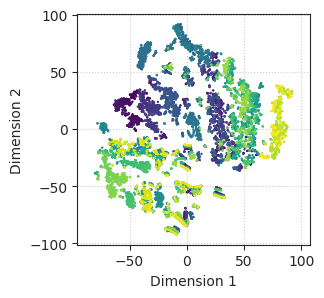

In [42]:
eleComb = 'MNP'

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(MNPFeatsDF)

# Visualise data via t-SNE
plot_tsne(Xscaled, figNamePrefix=eleComb, perplexity=30, markerSize=0.5, n_jobs=NUM_JOBS)

In [ ]:
# Run iterative archetypal analysis over a range of number of archetypes
numArchetypesRange = range(50, 301, 50)
runTimes, expVars, closestSampleIdxs = [], [], []
for numArchetypes in numArchetypesRange:
    numSubset = 10
    iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                             C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                             random_state=RANDOM_STATE, numThreads=NUM_JOBS)
    iAA.fit(Xscaled)
    iAA._extract_close_match()
    runTimes.append(iAA.run_time)
    expVars.append(iAA.explained_variance_)
    closestSampleIdxs.append([sampleIdx for (sampleIdx, archetype) in iAA.close_match.values()])

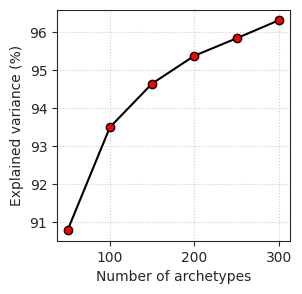

In [58]:
# Elbow plot to decide number of archetypes
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, [expVar*100 for expVar in expVars], 
         color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Explained variance (%)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}expVar.png", bbox_inches='tight')

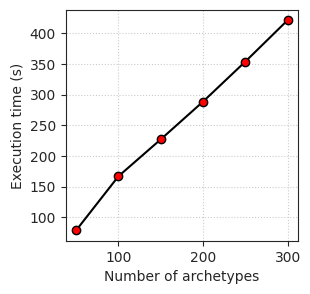

In [59]:
# Growth in execution time as number of archetypes increases
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, runTimes, color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Execution time (s)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}exeTime.png", bbox_inches='tight')

In [ ]:
# Visualise the difference in most archetypal samples as number of archetypes changes
for (i, idxs) in enumerate(closestSampleIdxs):
    plot_tsne(Xscaled, figNamePrefix=f"{eleComb}_{numArchetypesRange[i]}p_iAA", perplexity=30, markerSize=0.5, n_jobs=NUM_JOBS, markIdxs=idxs)

In [14]:
# Rerun iterative archetypal analysis with the decided number of archetypes
numArchetypes = 100
numSubset = 10
iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
iAA.fit(Xscaled)
print(f"Iterative archetypal analysis execution time: {iAA.run_time:.3f} s")
print(f"Explained variance: {iAA.explained_variance_:.6f}\n")

RSS FISTA = 32633.975
RSS FISTA = 17399.804
RSS FISTA = 12372.356
RSS AS = 10088.935
RSS AS = 9410.1515
RSS AS = 9031.2131
RSS AS = 8743.4491
RSS AS = 8548.2756
RSS AS = 8414.4749
RSS AS = 8311.4737
RSS AS = 8204.778
RSS AS = 8063.8768
RSS AS = 7915.6745
RSS AS = 7795.9975
RSS AS = 7733.9386
RSS AS = 7699.8514
RSS AS = 7669.8603
RSS AS = 7633.7608
RSS AS = 7592.9593
RSS AS = 7552.0417
RSS AS = 7520.1018
RSS AS = 7499.4314
RSS AS = 7485.8045
RSS AS = 7476.3431
RSS AS = 7469.1955
RSS AS = 7463.4586
RSS AS = 7459.0314
RSS AS = 7455.1432
RSS AS = 7451.5474
RSS AS = 7448.0097
RSS AS = 7444.4511
RSS AS = 7440.6168
RSS AS = 7436.1728
RSS AS = 7430.7111
RSS AS = 7423.6977
RSS AS = 7414.3088
RSS AS = 7402.1777
RSS AS = 7388.5549
RSS AS = 7374.9065
RSS AS = 7361.3719
RSS AS = 7348.7701
RSS AS = 7337.3976
RSS AS = 7326.9583
RSS AS = 7316.6823
RSS AS = 7304.2108
RSS AS = 7288.1281
RSS AS = 7268.9496
RSS AS = 7245.9821
RSS AS = 7230.5067
RSS AS = 7226.4162
RSS AS = 7223.7852
RSS AS = 7221.5322
RSS 

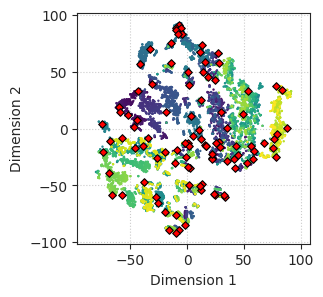

In [29]:
idxs = [3029, 8008, 3908, 4909, 7007, 1017, 8149, 8167, 2808, 5796, 2906, 3786, 4794, 3234, 6027, 4828, 903, 8267, 4795, 3014, 5908, 3973, 4790, 2990, 1128, 7328, 6118, 8604, 972, 2104, 114, 3949, 1791, 3903, 1003, 1782, 4793, 8246, 793, 3799, 7201, 3085, 3553, 1212, 5792, 800, 912, 210, 9191, 48, 795, 8360, 3176, 8290, 367, 3478, 9162, 4306, 7136, 3801, 3427, 4706, 2918, 8698, 769, 7071, 4292, 4491, 4309, 2630, 4458, 521, 4657, 130, 5899, 8820, 1098, 4101, 4484, 7432, 554, 8003, 472, 5474, 7626, 3703, 4545, 591, 6970, 7807, 4573, 4687, 7182, 9180, 7702, 4634, 9075, 864, 9134, 4534]
plot_tsne(Xscaled, figNamePrefix=f"{eleComb}_100p_iAA", perplexity=30, markerSize=0.5, n_jobs=NUM_JOBS, markIdxs=idxs)

#### Visualise outputs

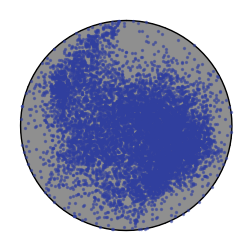

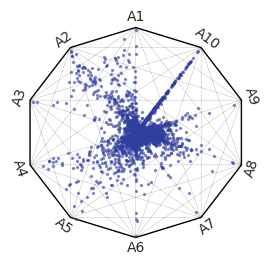

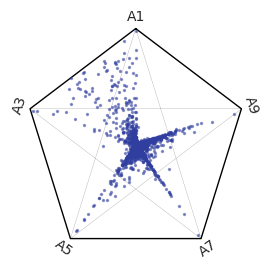

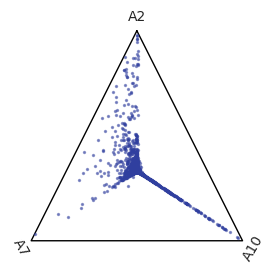

In [15]:
# Map data to restricted (numArchs) archetype spaces
iAA.plot_simplex(iAA.alfa, archIDs=list(range(iAA.n_archetypes)), showLabel=False, figNamePrefix=f"{eleComb}_allAs")  # All archetypes
iAA.plot_simplex(iAA.alfa, archIDs=list(range(10)), showLabel=True, figNamePrefix=f"{eleComb}_10As")
iAA.plot_simplex(iAA.alfa, archIDs=[0, 2, 4, 6, 8], showLabel=True, figNamePrefix=f"{eleComb}_5As")
iAA.plot_simplex(iAA.alfa, archIDs=[1, 6, 9], showLabel=True, figNamePrefix=f"{eleComb}_3As")

In [20]:
# Display all feature names
# print(list(zip([i for i in range(len(allfeatNames))], allfeatNames)))

# Select features of interest
allFeatNames = list(MNPFeatsDF.columns)
selectedFeatsIdxs = [
    0, 1, 2,  # Processing conditions
    3, 4, 5,  # Atom counts
    6, 10,  # Sizes
    14, 15, 16, 17,  #Facets
    18, 19, 20, 21, 22, 23, 24, 25, # 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,  # Curvature
    36, 37, 38,  # Average coordination numbers
    102, 103,  # Bond length statistics
    109, 110, 111, 112,  # Crystal structures
    113, 114, 115,  # Number of bonded neighbours by Steinhardt's parameters
]

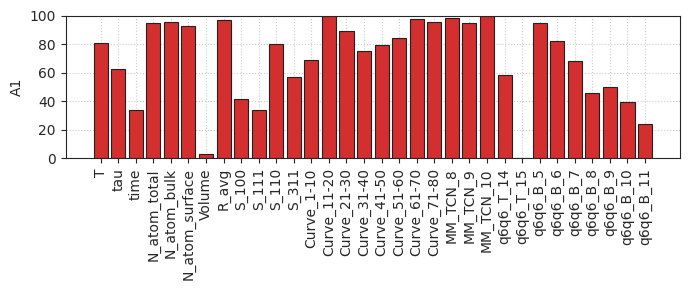

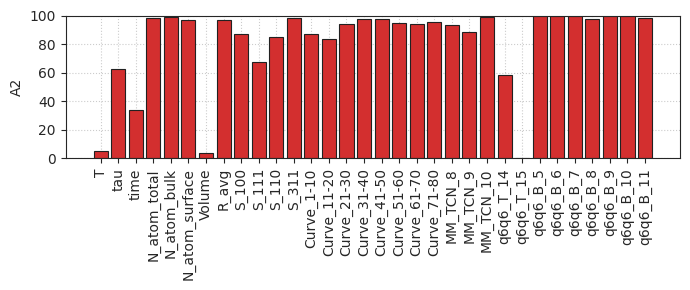

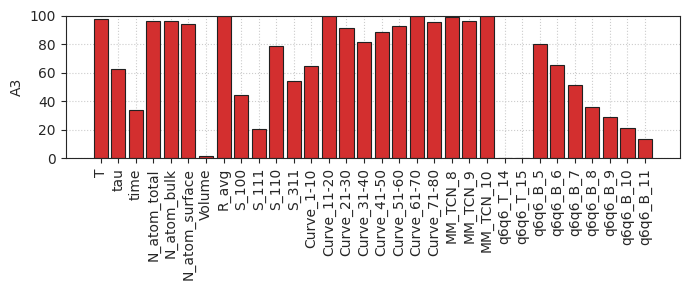

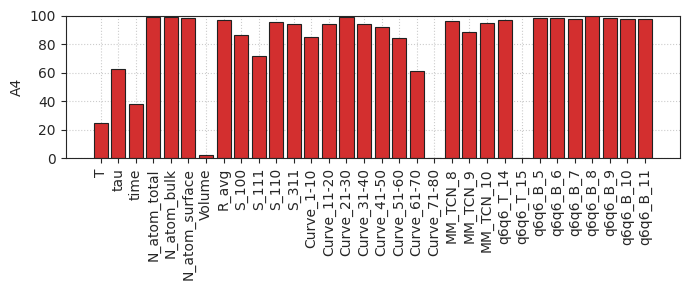

In [61]:
# Visualise archetype profile via bar plots
iAA.plot_profile(allFeatNames, selectedFeatsIdxs, archIDs=list(range(4)), figSize=(7, 3), figNamePrefix=eleComb)

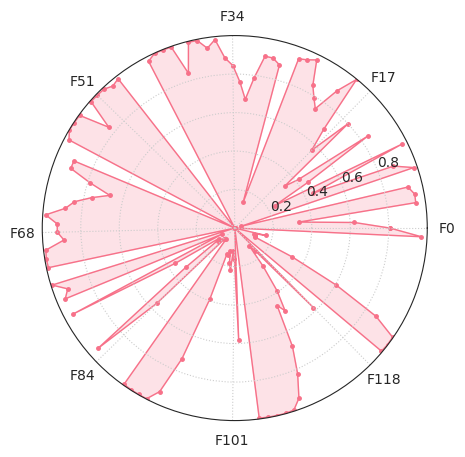

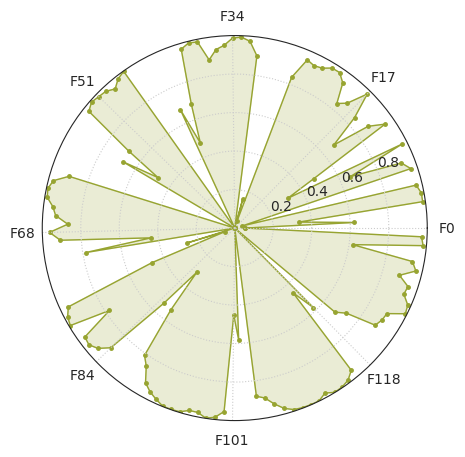

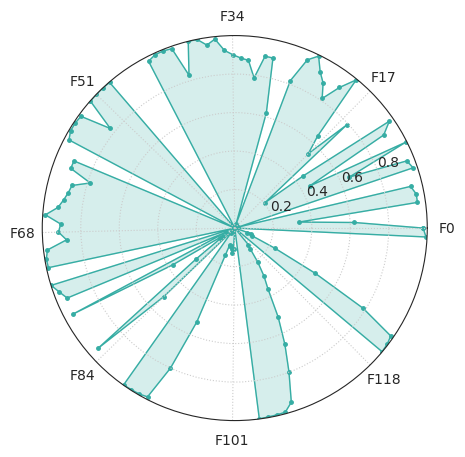

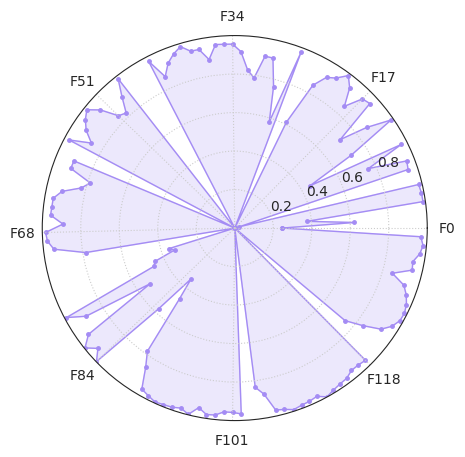

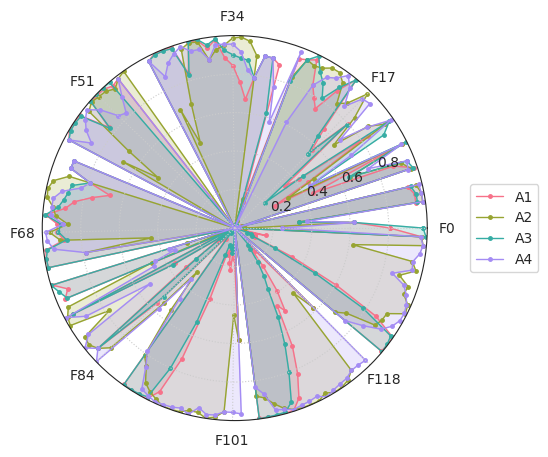

In [71]:
# Visualise archetype profile via radar plot
iAA.plot_radar_profile(allFeatNames, selectedFeatsIdxs=list(range(len(allFeatNames))), archIDs=list(range(4)), 
                       sepArchs=True, showLabel=True, labelAll=False, figSize=(5, 5), figNamePrefix=eleComb)  # Individual
iAA.plot_radar_profile(allFeatNames, selectedFeatsIdxs=list(range(len(allFeatNames))), archIDs=list(range(4)), 
                       sepArchs=False, showLabel=True, labelAll=False, figSize=(5, 5), figNamePrefix=eleComb)  # All in one

In [ ]:
# Visualise samples and archetypes on parallel axis
iAA.parallel_plot(allfeatNames, dfArgs[['color']].copy(), linewidth='0.3', arch_color='k')

### BNP

In [ ]:
eleComb = 'BNP'

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(BNPFeatsDF)

# Visualise data via t-SNE
# plot_tsne(Xscaled, figNamePrefix=eleComb, perplexity=30, markerSize=0.5, n_jobs=NUM_JOBS)

In [ ]:
# Run iterative archetypal analysis over a range of number of archetypes
numArchetypesRange = range(1000, 5001, 1000)
runTimes, expVars, closestSampleIdxs = [], [], []
for numArchetypes in numArchetypesRange:
    numSubset = 10
    iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                             C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                             random_state=RANDOM_STATE, numThreads=NUM_JOBS)
    iAA.fit(Xscaled)
    iAA._extract_close_match()
    runTimes.append(iAA.run_time)
    expVars.append(iAA.explained_variance_)
    closestSampleIdxs.append([sampleIdx for (sampleIdx, archetype) in iAA.close_match.values()])

In [ ]:
# Elbow plot to decide number of archetypes
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, [expVar*100 for expVar in expVars], 
         color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Explained variance (%)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}expVar.png", bbox_inches='tight')

In [ ]:
# Growth in execution time as number of archetypes increases
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, runTimes, color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Execution time (s)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}exeTime.png", bbox_inches='tight')

In [69]:
# Rerun iterative archetypal analysis with the decided number of archetypes
numArchetypes = 100
numSubset = 10
iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
iAA.fit(Xscaled)
print(f"Iterative archetypal analysis execution time: {iAA.run_time:.3f} s")
print(f"Explained variance: {iAA.explained_variance_:.6f}\n")

RSS FISTA = 32633.975
RSS FISTA = 17399.804
RSS FISTA = 12372.356
RSS AS = 10088.935
RSS AS = 9410.1515
RSS AS = 9031.2131
RSS AS = 8743.4491
RSS AS = 8548.2756
RSS AS = 8414.4749
RSS AS = 8311.4737
RSS AS = 8204.778
RSS AS = 8063.8768
RSS AS = 7915.6745
RSS AS = 7795.9975
RSS AS = 7733.9386
RSS AS = 7699.8514
RSS AS = 7669.8603
RSS AS = 7633.7608
RSS AS = 7592.9593
RSS AS = 7552.0417
RSS AS = 7520.1018
RSS AS = 7499.4314
RSS AS = 7485.8045
RSS AS = 7476.3431
RSS AS = 7469.1955
RSS AS = 7463.4586
RSS AS = 7459.0314
RSS AS = 7455.1432
RSS AS = 7451.5474
RSS AS = 7448.0097
RSS AS = 7444.4511
RSS AS = 7440.6168
RSS AS = 7436.1728
RSS AS = 7430.7111
RSS AS = 7423.6977
RSS AS = 7414.3088
RSS AS = 7402.1777
RSS AS = 7388.5549
RSS AS = 7374.9065
RSS AS = 7361.3719
RSS AS = 7348.7701
RSS AS = 7337.3976
RSS AS = 7326.9583
RSS AS = 7316.6823
RSS AS = 7304.2108
RSS AS = 7288.1281
RSS AS = 7268.9496
RSS AS = 7245.9821
RSS AS = 7230.5067
RSS AS = 7226.4162
RSS AS = 7223.7852
RSS AS = 7221.5322
RSS 

In [30]:
# Visualise the difference in most archetypal samples as number of archetypes changes
for (i, idxs) in enumerate(closestSampleIdxs):
    plot_tsne(Xscaled, figNamePrefix=f"{eleComb}_{numArchetypesRange[i]}p_iAA", perplexity=30, markerSize=0.5, n_jobs=NUM_JOBS, markIdxs=idxs)

[3029, 8008, 3908, 4909, 7007, 1017, 8149, 8167, 2808, 5796, 2906, 3786, 4794, 3234, 6027, 4828, 903, 8267, 4795, 3014, 5908, 3973, 4790, 2990, 1128, 7328, 6118, 8604, 972, 2104, 114, 3949, 1791, 3903, 1003, 1782, 4793, 8246, 793, 3799, 7201, 3085, 3553, 1212, 5792, 800, 912, 210, 9191, 48, 795, 8360, 3176, 8290, 367, 3478, 9162, 4306, 7136, 3801, 3427, 4706, 2918, 8698, 769, 7071, 4292, 4491, 4309, 2630, 4458, 521, 4657, 130, 5899, 8820, 1098, 4101, 4484, 7432, 554, 8003, 472, 5474, 7626, 3703, 4545, 591, 6970, 7807, 4573, 4687, 7182, 9180, 7702, 4634, 9075, 864, 9134, 4534]


### TNP

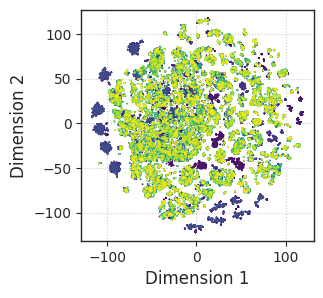

In [188]:
eleComb = 'TNP'

# Standardise data
sc = StandardScaler()
Xscaled = sc.fit_transform(TNPFeatsDF)

# Visualise data via t-SNE
plot_tsne(Xscaled, figNamePrefix=eleComb, perplexity=30, markerSize=0.5, n_jobs=NUM_JOBS)

In [ ]:
# Run iterative archetypal analysis over a range of number of archetypes
numArchetypesRange = range(100, 501, 100)
runTimes, expVars, closestSampleIdxs = [], [], []
for numArchetypes in numArchetypesRange:
    numSubset = 10
    iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                             C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                             random_state=RANDOM_STATE, numThreads=NUM_JOBS)
    iAA.fit(Xscaled)
    iAA._extract_close_match()
    runTimes.append(iAA.run_time)
    expVars.append(iAA.explained_variance_)
    closestSampleIdxs.append([sampleIdx for (sampleIdx, archetype) in iAA.close_match.values()])

RSS FISTA = 2406467.2
RSS FISTA = 1765975.7
RSS FISTA = 1583605.1
RSS AS = 1440796.1
RSS AS = 1399038.6
RSS AS = 1375280.8
RSS AS = 1361035
RSS AS = 1346651.4
RSS AS = 1330412.8
RSS AS = 1316070.4
RSS AS = 1310505.4
RSS AS = 1307551.7
RSS AS = 1305409.9
RSS AS = 1303808.2
RSS AS = 1302554.8
RSS AS = 1301491.7
RSS AS = 1300575.1
RSS AS = 1299789
RSS AS = 1299081.2
RSS AS = 1298464.5
RSS AS = 1297889.9
RSS AS = 1297344.4
RSS AS = 1296830.4
RSS AS = 1296344.2
RSS AS = 1295871.5
RSS AS = 1295393.1
RSS AS = 1294884.3
RSS AS = 1294291.1
RSS AS = 1293461.4
RSS AS = 1291755.9
RSS AS = 1286075.4
RSS AS = 1273531.5
RSS AS = 1270879.6
RSS AS = 1269407.3
RSS AS = 1268072.8
RSS AS = 1266908.6
RSS AS = 1266000.3
RSS AS = 1265413.1
RSS AS = 1265038
RSS AS = 1264768.7
RSS AS = 1264543.7
RSS AS = 1264340
RSS AS = 1264144.2
RSS AS = 1263953.5
RSS AS = 1263787
RSS AS = 1263631.6
RSS AS = 1263488.4
RSS AS = 1263351.8
RSS AS = 1263207.9
RSS AS = 1263044.6
RSS AS = 1262856.5
RSS AS = 1262646.3
RSS AS = 1262

In [ ]:
# Elbow plot to decide number of archetypes
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, [expVar*100 for expVar in expVars], 
         color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Explained variance (%)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}expVar.png", bbox_inches='tight')

In [ ]:
# Growth in execution time as number of archetypes increases
plt.figure(figsize=(3, 3), dpi=DPI)
plt.plot(numArchetypesRange, runTimes, color='k', marker='o', markersize=6, markerfacecolor='r', markeredgecolor='k', markeredgewidth=1)
plt.xlabel('Number of archetypes')
plt.ylabel('Execution time (s)')
plt.grid(linestyle='dotted')
plt.savefig(f"figures/{eleComb}exeTime.png", bbox_inches='tight')

In [69]:
# Rerun iterative archetypal analysis with the decided number of archetypes
numArchetypes = 100
numSubset = 10
iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
iAA.fit(Xscaled)
print(f"Iterative archetypal analysis execution time: {iAA.run_time:.3f} s")
print(f"Explained variance: {iAA.explained_variance_:.6f}\n")

RSS FISTA = 32633.975
RSS FISTA = 17399.804
RSS FISTA = 12372.356
RSS AS = 10088.935
RSS AS = 9410.1515
RSS AS = 9031.2131
RSS AS = 8743.4491
RSS AS = 8548.2756
RSS AS = 8414.4749
RSS AS = 8311.4737
RSS AS = 8204.778
RSS AS = 8063.8768
RSS AS = 7915.6745
RSS AS = 7795.9975
RSS AS = 7733.9386
RSS AS = 7699.8514
RSS AS = 7669.8603
RSS AS = 7633.7608
RSS AS = 7592.9593
RSS AS = 7552.0417
RSS AS = 7520.1018
RSS AS = 7499.4314
RSS AS = 7485.8045
RSS AS = 7476.3431
RSS AS = 7469.1955
RSS AS = 7463.4586
RSS AS = 7459.0314
RSS AS = 7455.1432
RSS AS = 7451.5474
RSS AS = 7448.0097
RSS AS = 7444.4511
RSS AS = 7440.6168
RSS AS = 7436.1728
RSS AS = 7430.7111
RSS AS = 7423.6977
RSS AS = 7414.3088
RSS AS = 7402.1777
RSS AS = 7388.5549
RSS AS = 7374.9065
RSS AS = 7361.3719
RSS AS = 7348.7701
RSS AS = 7337.3976
RSS AS = 7326.9583
RSS AS = 7316.6823
RSS AS = 7304.2108
RSS AS = 7288.1281
RSS AS = 7268.9496
RSS AS = 7245.9821
RSS AS = 7230.5067
RSS AS = 7226.4162
RSS AS = 7223.7852
RSS AS = 7221.5322
RSS 

In [30]:
# Visualise the difference in most archetypal samples as number of archetypes changes
for (i, idxs) in enumerate(closestSampleIdxs):
    plot_tsne(Xscaled, figNamePrefix=f"{eleComb}_{numArchetypesRange[i]}p_iAA", perplexity=30, markerSize=0.5, n_jobs=NUM_JOBS, markIdxs=idxs)

[3029, 8008, 3908, 4909, 7007, 1017, 8149, 8167, 2808, 5796, 2906, 3786, 4794, 3234, 6027, 4828, 903, 8267, 4795, 3014, 5908, 3973, 4790, 2990, 1128, 7328, 6118, 8604, 972, 2104, 114, 3949, 1791, 3903, 1003, 1782, 4793, 8246, 793, 3799, 7201, 3085, 3553, 1212, 5792, 800, 912, 210, 9191, 48, 795, 8360, 3176, 8290, 367, 3478, 9162, 4306, 7136, 3801, 3427, 4706, 2918, 8698, 769, 7071, 4292, 4491, 4309, 2630, 4458, 521, 4657, 130, 5899, 8820, 1098, 4101, 4484, 7432, 554, 8003, 472, 5474, 7626, 3703, 4545, 591, 6970, 7807, 4573, 4687, 7182, 9180, 7702, 4634, 9075, 864, 9134, 4534]


## Extra

Below is a list of the attributes that could be extracted. Note that $n$, $m$, and $k$ refers to the number of samples, number of features, and number of archetypes, respectively:
- **.archetypes** returns $Z$ (with a shape of $(m \times k)$), the computed archetypes.
- **.alfa** returns $A$ (with a shape of $(k \times n)$), the coefficient matrix to multiply to $Z$ to approximately reconstruct $X$.
- **.beta** returns $B$ (with a shape of $(n \times k)$), the coefficient matrix to multiply to $X$ to obtain $Z$.
- **.X** returns $X^T$ (with a shape of $(m \times n)$), the transposed original data.
- **.X_approx** returns $X_{\text{approx}}$ (with a shape of $(m \times n)$), the reconstructed data.
- **.explained_variance_** tells how close is $X_{\text{approx}}$ to $X$. It is computed using *explained_variance_score()* from the *sklearn* package.
- **.archetype_profile** provides the profile of the archetypes (with a shape of $(m \times n)$). It shows the fraction of importance of each feature for each archetype (which sums to 1.0).
- **.close_match** contains the most archetypal data points. It is only computed after **._extract_close_match()** is run.
- **.run_time** returns the execution duration (s) of the algorithm for $Z$ to be computed.

The following outputs are only useful when *iterative* is set to *True*:
- **.subsets_sample_idxs** returns the indices of the samples for each data subset.
- **.subsets_Zs** returns the archetypes obtained from each data subset.

In [12]:
print(f"Z:\n{AA.archetypes}\n")  # (m*k)
print(f"A:\n{AA.alfa}\n")  # (k*n)
print(f"B:\n{AA.beta}\n")  # (n*k)
print(f"X:\n{AA.X}\n")  # (m*n)
print(f"Approximately reconstructed X:\n{AA.X_approx}\n")  # (m*n)
print(f"Explained variance:\n{AA.explained_variance_:.6f}\n")
print(f"Archetype profiles:\n{AA.archetype_profile}\n")  # (m*n)
print(f"Execution time (s):\n{AA.run_time:.6f}\n")
AA._extract_close_match()
print(f"Most archetypal data samples:\n{AA.close_match:.6f}\n")
print(f"Subset sample IDs:\n{AA.subsets_sample_idxs}\n")
print(f"Subset archetypes:\n{AA.subsets_Zs}\n")

Z:
[[-1.81373673e+00  2.33253870e+00  4.67862062e-01  2.57260154e+00
   8.34833843e-03  1.16177085e+00 -1.31939049e+00  6.46751539e-01
  -1.38039633e-03 -1.12939096e-01]
 [-1.92653645e+00  1.62173079e+00 -3.53184629e-01  1.31156620e+00
   3.31802788e+00  1.76458341e+00 -1.69040211e+00  3.44977640e-02
   1.48311560e-01  1.22060091e+00]
 [-2.17349899e+00  3.14042362e-01  1.54350717e+00  1.53322242e+00
   2.32443573e+00  1.09656016e+00 -7.64578013e-01  1.28167800e-01
  -6.53182262e-01 -1.35502852e-01]
 [-1.82423332e+00  2.72699245e+00  1.28987940e+00  5.39244969e-01
   1.57060104e+00  3.28300188e-01 -1.99230678e+00 -1.82133039e+00
  -4.68377963e-01  2.57256431e+00]
 [-9.63567310e-01  1.93895991e+00  1.57530439e+00  1.22704228e+00
   1.23942139e+00  1.18696025e-01 -3.99967367e+00 -9.99833814e-02
  -7.12125466e-01  2.02513215e+00]
 [-2.20738044e+00  1.90041953e+00  1.65632621e+00  1.24318352e+00
   1.35735916e+00  1.07087112e+00 -1.14674028e+00  9.89328601e-02
  -3.29151575e-01  4.32559093e

TypeError: unsupported format string passed to dict.__format__

### Selecting the Appropriate Number of Archetypes

Here we use the elbow criterion to figure out the most appropriate choice of number of archetypes, $k$.

RSS FISTA = 784.08413
RSS FISTA = 662.3076
RSS FISTA = 632.97032
RSS AS = 618.04299
RSS AS = 610.08745
RSS AS = 604.54776
RSS AS = 600.6536
RSS AS = 597.84616
RSS AS = 595.69858
RSS AS = 593.9636
RSS AS = 592.56501
RSS AS = 591.42661
RSS AS = 590.47497
RSS AS = 589.71136
RSS AS = 589.26078
RSS AS = 589.14289
RSS AS = 588.81526
RSS AS = 588.40379
RSS AS = 588.07631
RSS AS = 587.81513
RSS AS = 587.60716
RSS AS = 587.44277
RSS AS = 587.3167
RSS AS = 587.22063
RSS AS = 587.15106
RSS AS = 587.10078
RSS AS = 587.06224
RSS AS = 587.03238
RSS AS = 587.0096
RSS AS = 586.99186
RSS AS = 586.97808
RSS AS = 586.9674
RSS AS = 586.95913
RSS AS = 586.95273
RSS AS = 586.94778
RSS AS = 586.9441
RSS AS = 586.94178
RSS AS = 586.94035
RSS AS = 586.93946
RSS AS = 586.93891
RSS AS = 586.93856
RSS AS = 586.93835
RSS AS = 586.93822
RSS AS = 586.93813
RSS AS = 586.93808
RSS AS = 586.93805
RSS AS = 586.93803
RSS AS = 586.93802
RSS AS = 586.93801
RSS AS = 586.93801
RSS AS = 586.938
RSS AS = 586.938
RSS AS = 586.9

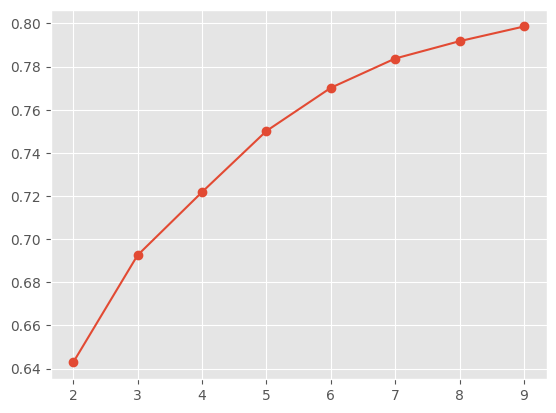

In [13]:
numSubset = 3
allNumArchetypes, expVars = range(2, 10), []
for numArchetypes in allNumArchetypes:
    AAiterative = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                                     C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                                     random_state=RANDOM_STATE, numThreads=NUM_JOBS)
    AAiterative.fit(Xscaled)
    expVars.append(AAiterative.explained_variance_)
plt.style.use('ggplot')
plt.plot(allNumArchetypes, expVars, '-o');

### Mapping Data to Archetype Space

We can map the data samples to the convex hull formed by the archetypes using simplex plots.

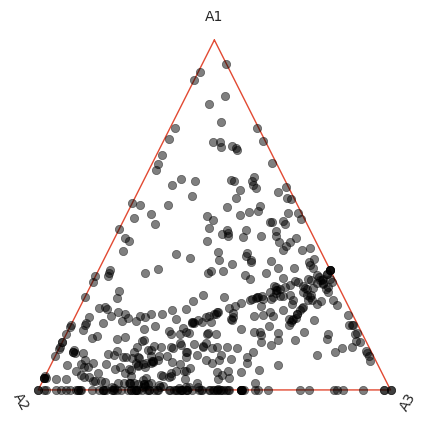

In [15]:
AA.plot_simplex(AA.alfa)

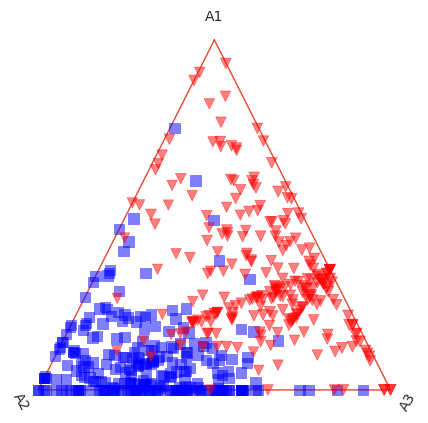

In [16]:
# Users have the flexibility to assign attributes (marker color, marker shape, marker size) to the data samples to enrich the plot.
dfArgs = df[['Gender']].copy()
dfArgs.loc[:, 'color'] = 'red'
dfArgs['color'][dfArgs['Gender']=='female'] = 'blue'

dfArgs.loc[:, 'marker'] = 'v'
dfArgs['marker'][dfArgs['Gender']=='female'] = 's'

dfArgs.loc[:, 'size'] = df[['Height']] / 3

plotArgs = {'color': dfArgs['color'], 's': dfArgs['size'], 'marker': dfArgs['marker']}

AA.plot_simplex(AA.alfa, plotArgs)

Additional utility functions are included to allow more flexibities to create simplex plots and color the data points in different fashions. This requires three steps:
1. Create the simplex plot frame with **create_simplex_ax** utility function.
2. Map the **.alfa** values to the simplex frame using the **map_alfa_to_simplex** utility function.
3. Use standard matplotlib scatter plot to visualise data points.

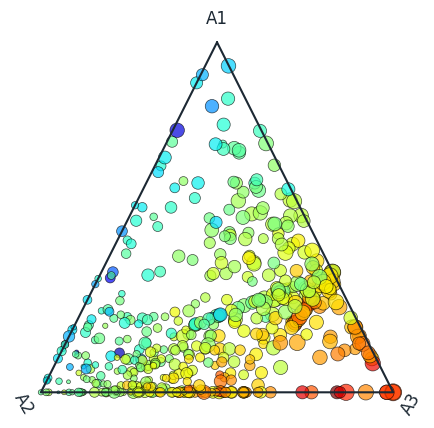

In [17]:
# STEP 1: Create the simplex plot. Users can control the color of gridlines and borders (edges) of the simplex plots. 
create_simplex_ax(AA, grid_on=True, gridcolor='#EAECEE', bordercolor='#1C2833', fontcolor='#1C2833', fig_size=(5, 5))
# STEP 2: Map the alfa values to simplex plot.
mappedAlfa = map_alfa_to_simplex(AA.alfa, AA)
# STEP 3: Use scatter plots to add the mapped alfa to simplex frame.
# The data points are colored by 'Biil' attribute, while sizes are correlated to normalised 'ChestDiam'.
df['ChestDiamNorm'] = (df['ChestDiam'] - df['ChestDiam'].min()) / (df['ChestDiam'].max() - df['ChestDiam'].min())
plt.scatter(mappedAlfa[:,0], mappedAlfa[:,1], 
            c=df['Biil'], cmap='jet', edgecolor='k', 
            s=df['ChestDiamNorm'] * 150, alpha=0.7);

Any other point (e.g. prototypes of clusters) can also be mapped to the simplex plot to compare their relative locations (with other points provided or the overall dataset).

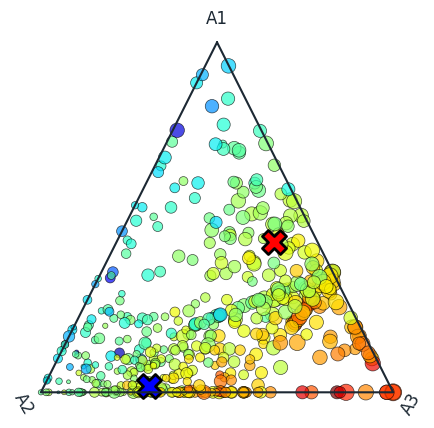

In [18]:
# STEP 1: Get the alpha values for males and females.
XavgMale = Xscaled[df['Gender'] == 'male'].mean(axis=0).reshape(1, -1)
XavgFemale = Xscaled[df['Gender'] == 'female'].mean(axis=0).reshape(1, -1)
_, alfaMale = AA.transform(XavgMale)
_, alfaFemale = AA.transform(XavgFemale)

# STEP 2: Create the simplex plot.
create_simplex_ax(AA, grid_on=True, gridcolor='#EAECEE', bordercolor='#1C2833', fontcolor='#1C2833', fig_size=(5, 5))

# STEP 3: Map the alphas values to the plot.
mappedAlfa = map_alfa_to_simplex(AA.alfa, AA)
mappedAlfaMale = map_alfa_to_simplex(alfaMale, AA)
mappedAlfaFemale = map_alfa_to_simplex(alfaFemale, AA)

# STEP 4: Plot the data samples.
df['ChestDiamNorm'] = (df['ChestDiam']-df['ChestDiam'].min()) / (df['ChestDiam'].max()-df['ChestDiam'].min())
plt.scatter(mappedAlfa[:, 0], mappedAlfa[:, 1], c=df['Biil'], cmap='jet', edgecolor='k', s=df['ChestDiamNorm'] * 150, alpha=0.7);
plt.scatter(mappedAlfaMale[:, 0], mappedAlfaMale[:, 1], marker='X', s=300, color='r', edgecolor='k', linewidth=2);
plt.scatter(mappedAlfaFemale[:, 0], mappedAlfaFemale[:, 1], marker='X', s=300, color='b', edgecolor='k', linewidth=2);

### Visualising Archetype Profiles

The profile of the archetypes can be plot as bar plots or radar plots.

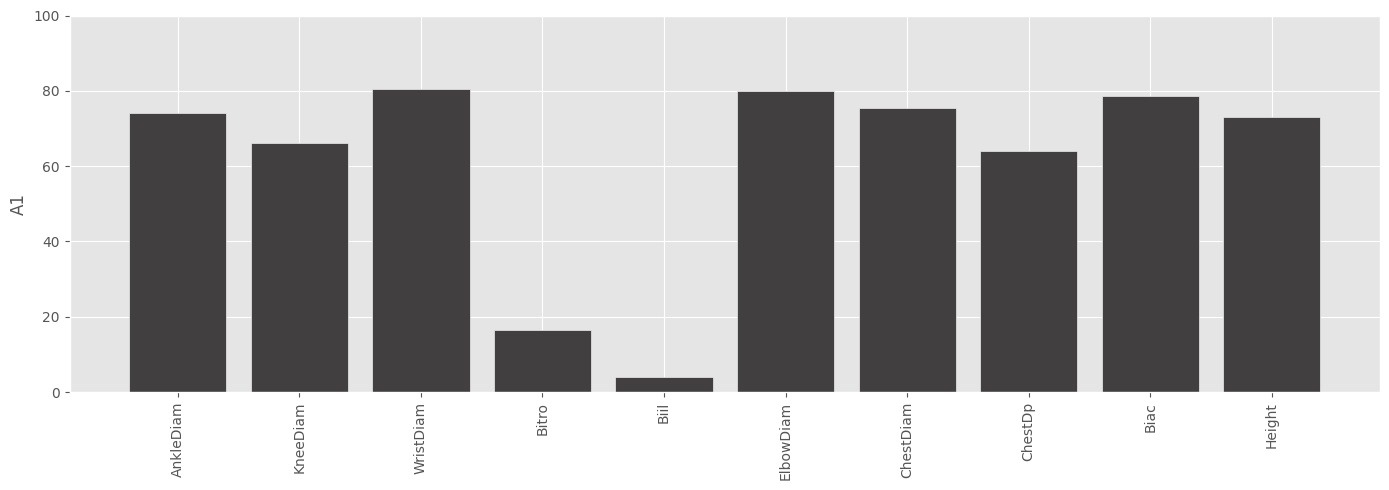

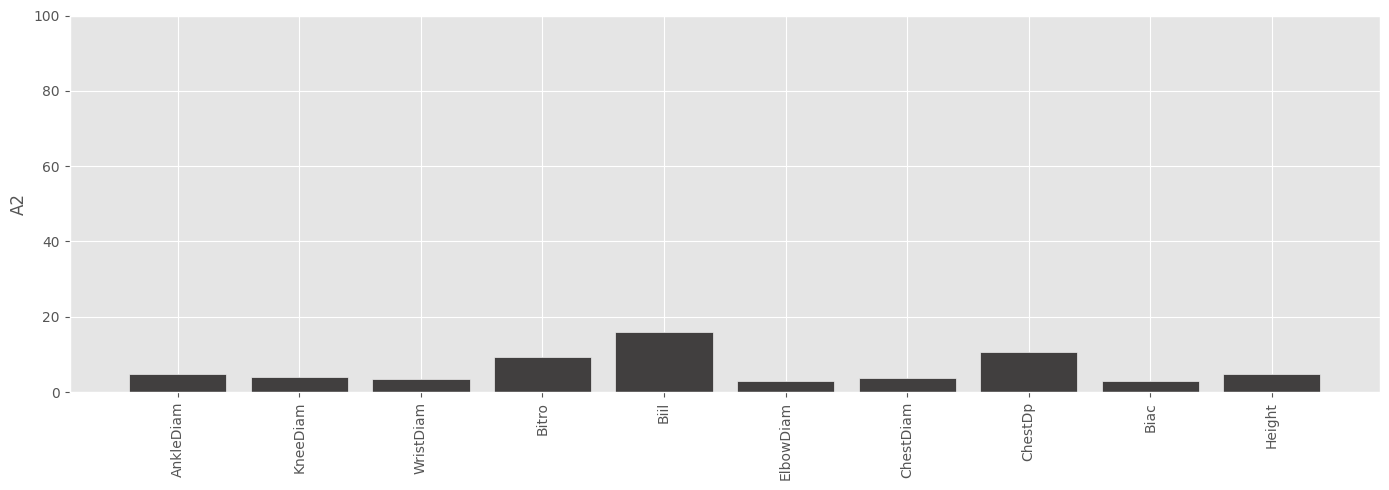

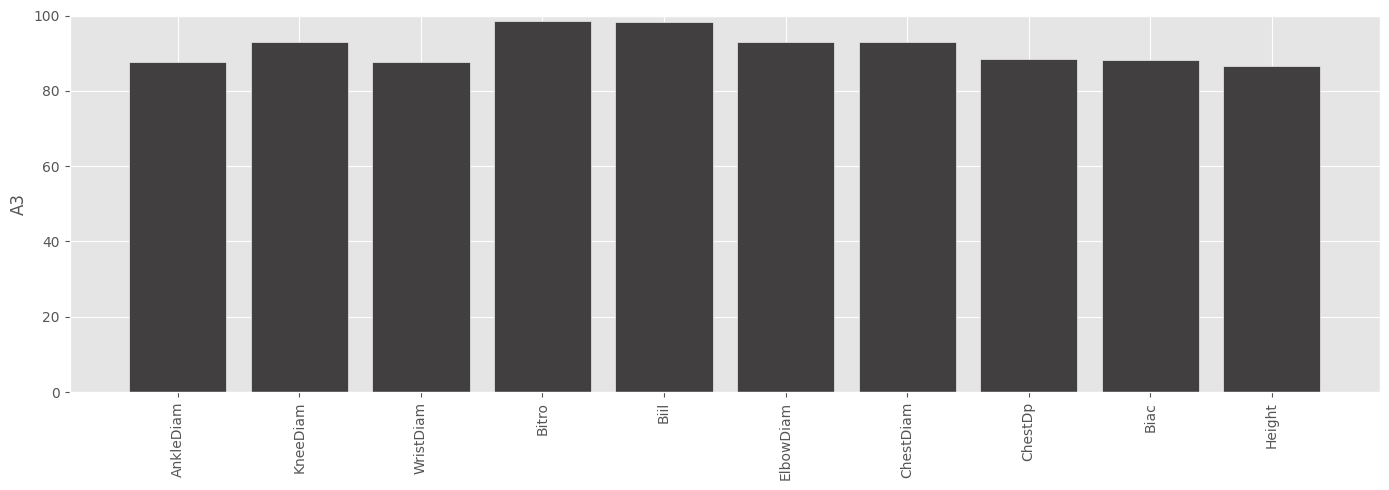

In [19]:
AA.plot_profile(featNames)

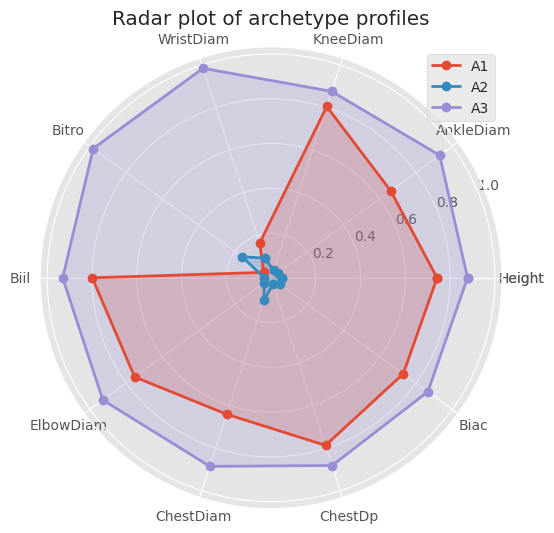

In [20]:
AA.plot_radar_profile(feature_cols=featNames, Title='Radar plot of archetype profiles')

### Identifying Most Archetypal Data Samples

The most archetypal data samples could be identified by running **._extract_close_match()** on the **ArchetypalAnalysis()** object.

Regarding the **.close_match** object:
- The keys are the archetypes.
- The first item in the tuple gives the index of the most archetypal data sample.
- The second item is the corresponding $\alpha$ array of that data point.

The data samples can be mapped to a simplex plot or displayed on a radar plot.

In [21]:
AA._extract_close_match()
AA.close_match

{1: (109, array([0.76479943, 0.09884301, 0.13635756])),
 2: (249, array([0.        , 0.92027823, 0.07972177])),
 3: (144, array([0.10426882, 0.01347575, 0.88225544]))}

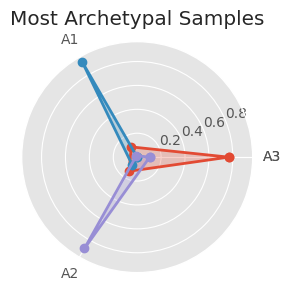

In [22]:
# Radar plot of the most archetypal data samples in the archetype space
AA.plot_close_match(Title='Most Archetypal Samples')

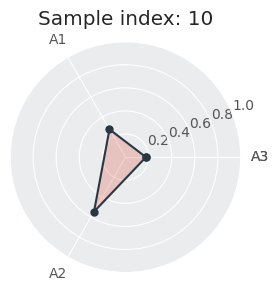

In [23]:
# Any data sample in the archetype space can also be plotted
idx = 10
plot_radar_datapoint(AA, Xscaled[idx, :].reshape(1,-1), Title=f"Sample index: {idx}");

### Visualing Samples and Archetypes on Parallel Axis

The data samples and archetypes could also be plotted on a parallel axis.

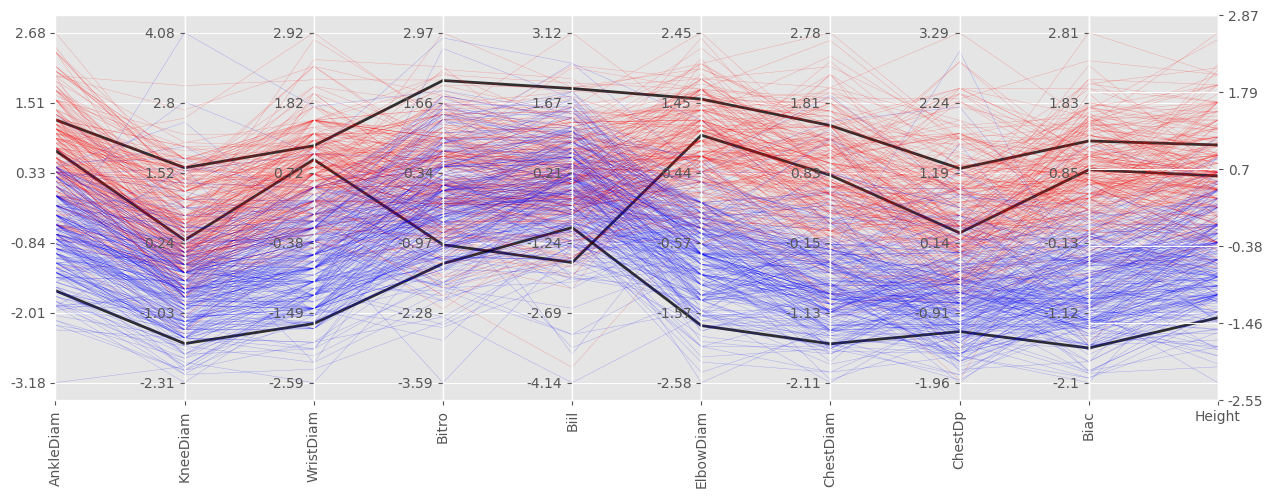

In [24]:
AA.parallel_plot(featNames, dfArgs[['color']].copy(), linewidth='0.3', arch_color='k')